<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#Resampling-by-one-hour." data-toc-modified-id="Resampling-by-one-hour.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resampling by one hour.</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model training</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Test-CatBoost" data-toc-modified-id="Test-CatBoost-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test CatBoost</a></span></li></ul></div>

#  Forecast of taxi orders

The company «Чётенькое такси» has collected historical data on taxi orders at airports. To attract more drivers during peak load periods, it is necessary to forecast the number of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric value on the test set should not exceed 48.

You need to:

1. Load the data and resample it by one hour.
2. Analyze the data.
3. Train different models with various hyperparameters. Create a test set that is 10% of the original data.
4. Validate the data on the test set and draw conclusions.


# Project Description

The data is in the file /datasets/taxi.csv.

The number of orders is in the 'num_orders' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np

# graphics
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    data= pd.read_csv("/datasets/taxi.csv", parse_dates=[0], index_col=[0])
except:
    data= pd.read_csv("taxi.csv", parse_dates=[0], index_col=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
#let's check duplicates

data.duplicated().sum()

26415

In [7]:
data.head()


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
data.isna().sum()

num_orders    0
dtype: int64

array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

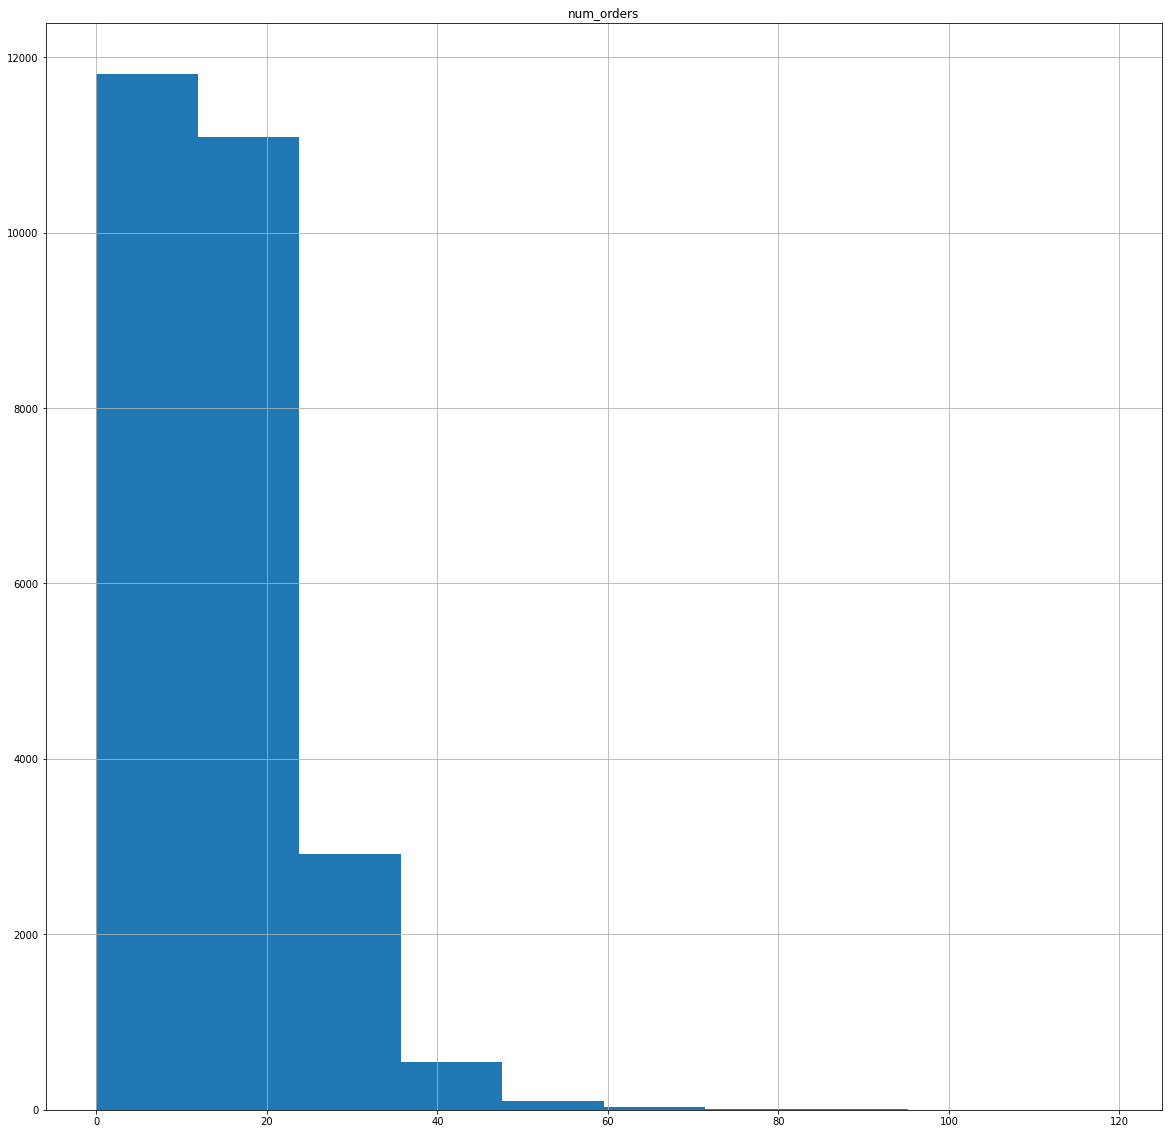

In [9]:
#Let's build histograms

data.hist(figsize=(20,20))

### Resampling by one hour.

<AxesSubplot:xlabel='datetime'>

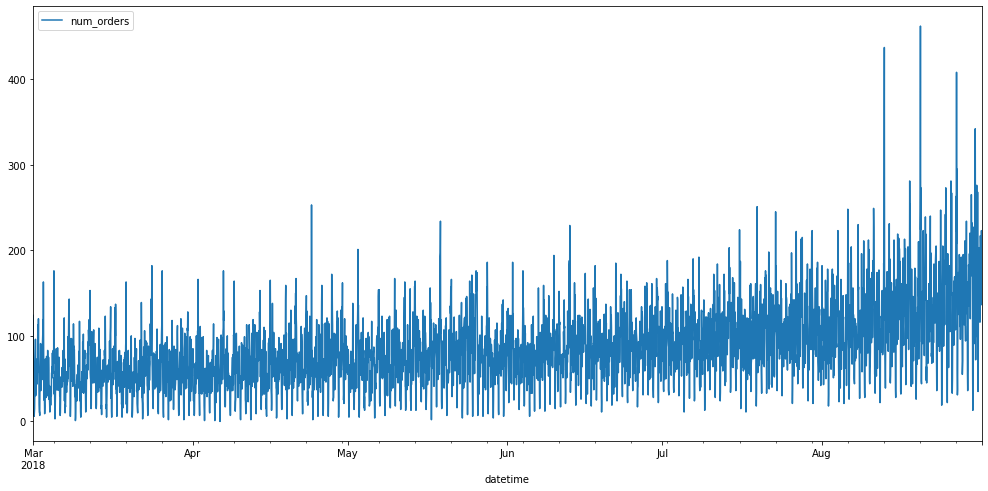

In [10]:
data = data.resample('1H').sum()
figsize = (17,8)
data.plot(figsize=figsize)

## Analysis

Let's divide the data into trend, seasonal and noise components and build the corresponding graphs

In [11]:
decomposed = seasonal_decompose(data)

In [12]:
sns.set(rc={'figure.figsize':(15,10)})

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

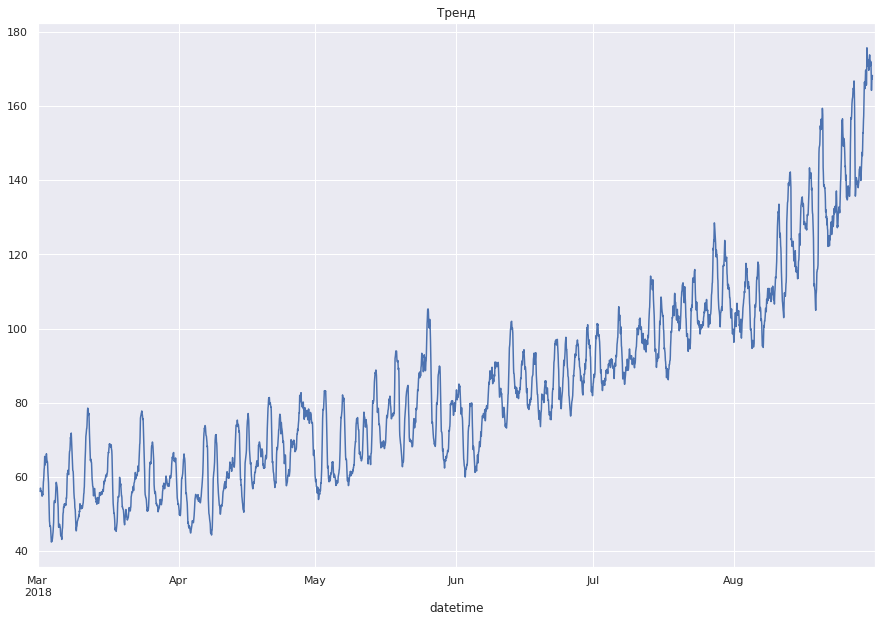

In [13]:
lineplot(decomposed.trend, 'Тренд')

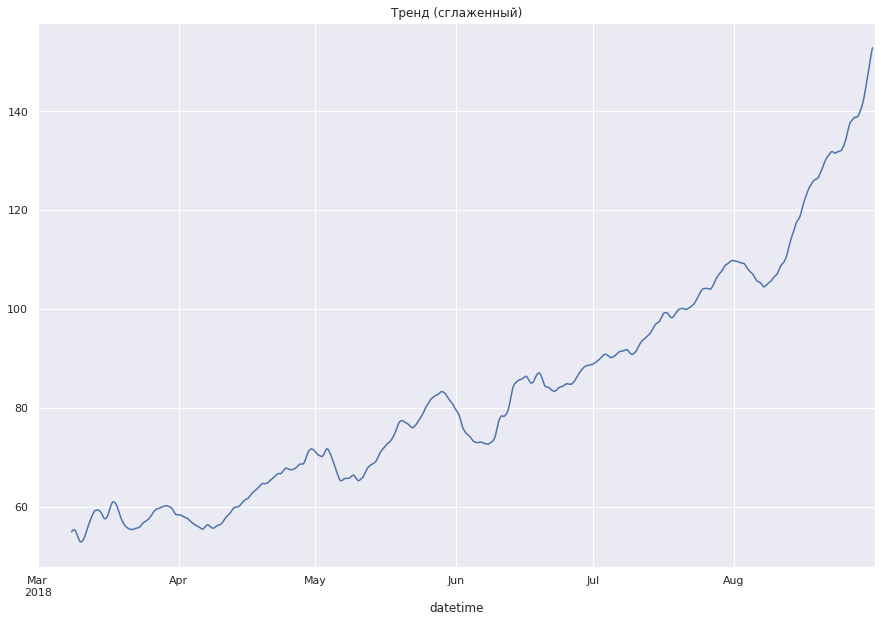

In [14]:
lineplot(decomposed.trend.rolling(24*7).mean(), 'Тренд (сглаженный)')

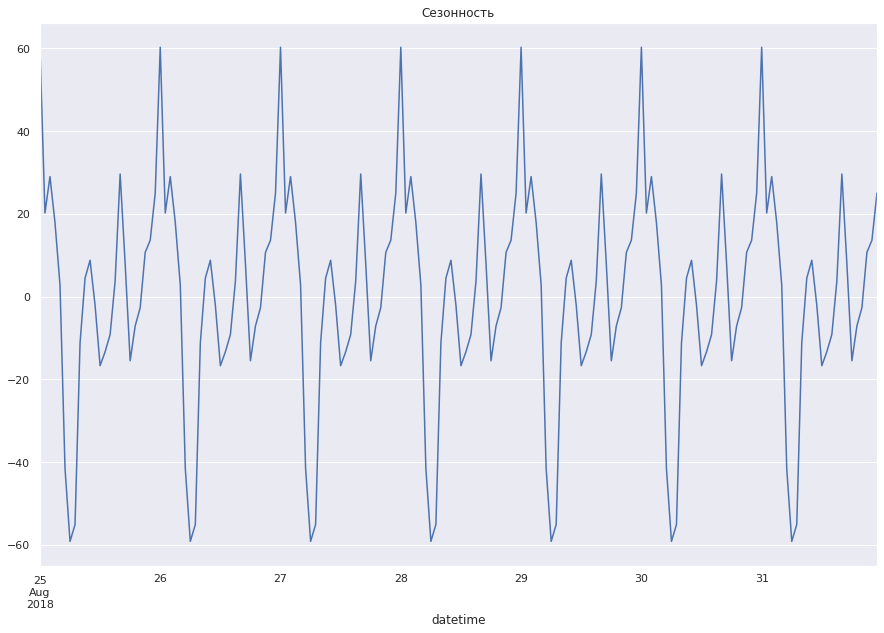

In [15]:
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')

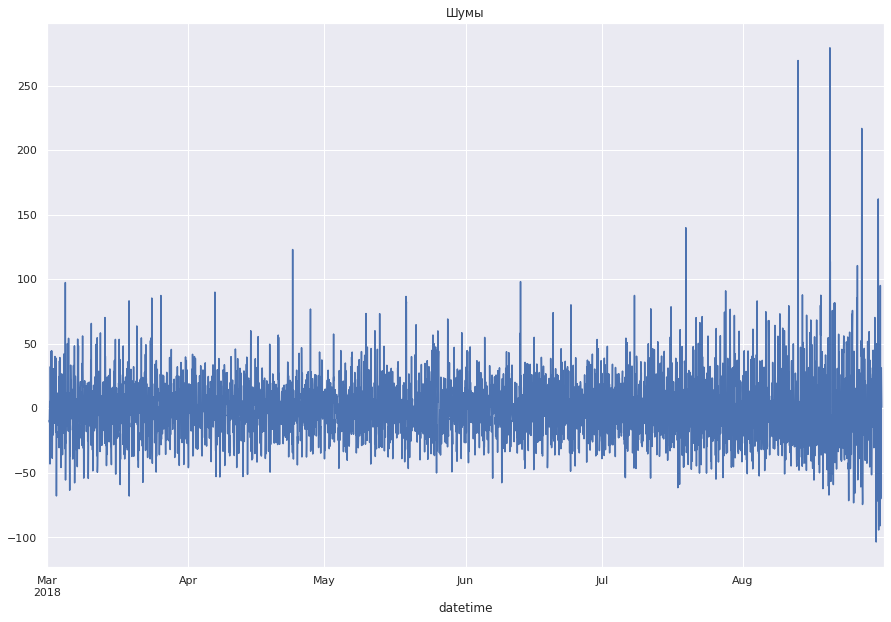

In [16]:
lineplot(decomposed.resid, 'Шумы')

<AxesSubplot:xlabel='datetime'>

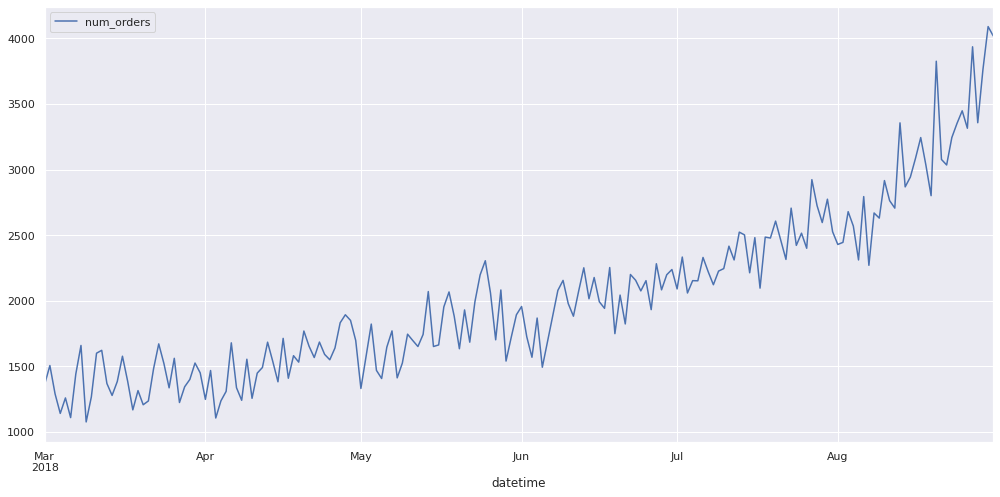

In [17]:
#Resampling by 1 day

data_1D = data.resample('1D').sum()
figsize = (17,8)
data_1D.plot(figsize=figsize)

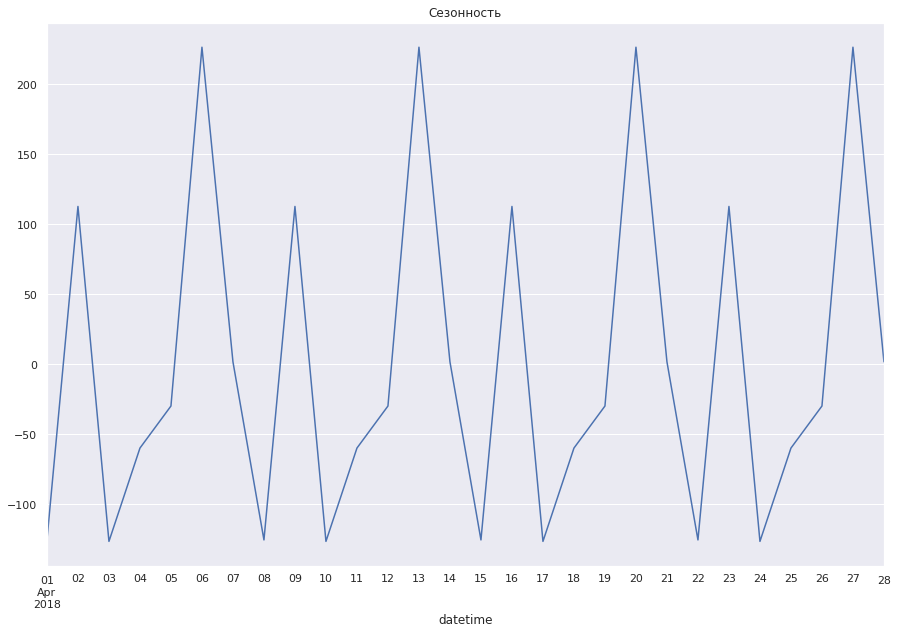

In [18]:
decomposed = seasonal_decompose(data_1D['2018-04-01':'2018-04-28'])
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')

Intermedia conclusions:

 - There is a trend of uniform growth of orders with periodic declines
 - There is seasonality by day - decline at night, increase in the morning and afternoon, peak in the evening
 - The graph shows that towards the end of the week and in the middle there is an increase in orders

## Model training

Feature Preparation: In my opinion, not all features are logically suitable. Here is my position:

Month Feature: NO, it is not suitable. We only have data for a few months, such as March and May, and not for a full year. Additionally, the forecasting horizon is in hours, so the seasonal trend for the time of year will already be embedded in the overall trend.
Day Feature: NO, this is also not suitable. We don't have intra-month seasonality, so it would just be a sequence of numbers.
Day of the Week Feature: YES, this is suitable because we have weekly seasonality.
Hour Feature: YES, this is suitable because there is hourly (daily) seasonality.
Lag Feature: YES, this is an autoregressive parameter that accounts for the influence of past events on the current situation.
Rolling Feature: YES, this is an analog of the trend. The larger the smoothing window, the smoother the trend line.

We will create features for a one-step forecasting horizon.

Since there is evident daily seasonality, the 'day' feature will be essential.

The trend shows an increase in orders towards the end of the week and in the middle, so we will add the 'dayofweek' feature.

Data varies month to month and exhibits cyclical patterns, so we will add the 'month' feature.

In [19]:
def get_features(data_learning):
    data_learning['dayofweek'] = data_learning.index.dayofweek
    data_learning['hour'] = data_learning.index.hour
    
    for lag in range(1, 6):
        data_learning['lag_{}'.format(lag)] = data_learning['num_orders'].shift(lag)
    
    data_learning['rolling_mean'] = data_learning['num_orders'].shift().rolling(1).mean()
    data_learning.dropna(inplace=True)
    
    return data_learning

<font color='blue'></font> \
<font color='blue'>
```python
max_lag = 24
for lag in range(1, max_lag):
```
Thus, a time shift of up to 24 can be specified. If this value is input into the get_features function, the number of lags in the data can be varied in a loop to evaluate the performance of models with the resulting data. Ultimately, the best lag size can be chosen.

- It's important to start with the idea that a model will perform better if optimal hyperparameters are selected for it.
- Hyperparameters are best tuned using cross-validation, which requires splitting the training dataset into folds. In time series, a specific type of split is needed where data is sorted by time without shuffling. Training is done on past data, and testing on more recent data. For instance, in train_test_split, the shuffle parameter should be set to False.
- Time series data requires specialized cross-validation methods like TimeSeriesSplit. This object is then passed to the cv parameter of GridSearchCV.
- In case of validation set approach instead of traditional cross-validation (which involves two sets: training and testing), the main requirement is that the datasets must be ordered by time in the sequence: training, validation, and then testing.
- I prefer cross-validation approach more. TimeSeriesSplit ensures that folds are ordered by time, with validation always following the training folds.

In [20]:
data_learning = data.copy()
data_learning = get_features(data_learning)

In [21]:
data_learning.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,43.0
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,6.0
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,12.0
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,15.0
2018-03-01 09:00:00,69,3,9,34.0,15.0,12.0,6.0,43.0,34.0


In [22]:
# Let's divide the data into training and test sets


features = data_learning.drop(['num_orders'], axis=1) 
target = data_learning['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)

In [23]:
models = []

### LinearRegression

In [24]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [25]:
predictions = model.predict(features_train)

In [26]:
tscv = TimeSeriesSplit(n_splits=2)

RMSE = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
RMSE

35.36082210475142

In [27]:
models.append([model, RMSE])

### DecisionTreeRegressor

In [28]:
model = DecisionTreeRegressor(random_state=12345)

parameters = {'max_depth':range(1,11,2)}

tscv = TimeSeriesSplit(n_splits=2)

In [29]:
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)
gsearch.fit(features_train, target_train)
gsearch.best_params_

{'max_depth': 7}

In [30]:
predictions = gsearch.predict(features_train)

In [31]:
tscv = TimeSeriesSplit(n_splits=2)

RMSE = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
RMSE

36.190726816174795

In [32]:
models.append([model, RMSE])

### LightGBM

In [33]:
model = lgb.LGBMRegressor()
model.fit(features_train, target_train, verbose=False)

LGBMRegressor()

In [34]:
predictions = model.predict(features_train)

In [35]:
tscv = TimeSeriesSplit(n_splits=2)

RMSE = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
RMSE

30.160537360949547

In [36]:
models.append([model, RMSE])

### CatBoost

In [37]:
model = CatBoostRegressor(verbose=False)
model.fit(features_train, target_train, verbose=False)

In [38]:
predictions = model.predict(features_train)

In [39]:
tscv = TimeSeriesSplit(n_splits=2)

RMSE = (cross_val_score(model, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
RMSE

30.064780632623503

In [40]:
models.append([model, RMSE])

Let's look at the summary table to determine which model is better

In [41]:
result = pd.DataFrame(models, columns=['model', 'rmse'])
display(result.sort_values(by='rmse'))

,model,rmse
3,<catboost.core.CatBoostRegressor object at 0x7...,30.064781
2,LGBMRegressor(),30.160537
0,LinearRegression(),35.360822
1,DecisionTreeRegressor(random_state=12345),36.190727


The CatBoost model is the best in terms of the RMSE metric on the training set - let’s test it

## Test CatBoost

In [42]:
model = CatBoostRegressor(verbose=False)
model.fit(features_train, target_train, verbose=False)

In [43]:
target_predict = model.predict(features_test)

In [44]:
final_RMSE= mean_squared_error(target_test, target_predict) ** 0.5     
print(final_RMSE)

47.03909092125978


# Final conclusion

In the course of the research, the following was performed:

- Data was loaded and preprocessed.
- Data was resampled at hourly intervals.
- Models were compared using different sets of hyperparameters.
- The best model was selected based on the RMSE metric. 
- Testing of this model was conducted.

Based on the data:

- There is a trend of steady growth in orders with periodic declines.
- There is daily seasonality - a drop at night, growth in the morning and during the day, with a peak in the evening.
- The chart shows an increase in orders towards the end of the week and in the middle of the week.

Recommendation to the customer: Based on the RMSE metric on the training dataset, the CatBoost model has proven to be the best model for forecasting the number of orders in the next hour. It is recommended to use this model for this task.
